## Applied Machine Learning Homework 3 Task 2

Peter Grantcharov (pdg2116), Po-Chieh Liu (pl2441)

**The overall goal is to predict whether a payment by a company to a medical doctor or facility was made as part of a research project or not.**

In [2]:
# import base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Task 2 Preprocessing and Baseline Model
1. Create a simple minimum viable model by doing an initial selection of features 
2. Doing appropriate preprocessing and cross-validating a linear model. 
3. Feel free to generously exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset

## Before Commencing
From task 1, we selected following features for building model predict the payment type:
1. Recipient_State
2. Recipient_Country
3. Physician_Primary_Type
4. Total_Amount_of_Payment_USDollars
5. Form_of_Payment_or_Transfer_of_Value
6. Dispute_Status_for_Publication
7. Related_Product_Indicator
8. Covered_or_Noncovered_Indicator_1
9. Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1

#### Import data

Based on task 1 results.

In [3]:
# Selected features
col = ["Recipient_State", 
       "Recipient_Country",
       "Physician_Primary_Type",
       "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID",
       "Total_Amount_of_Payment_USDollars",
       "Form_of_Payment_or_Transfer_of_Value",
       "Dispute_Status_for_Publication",
       "Related_Product_Indicator",
       "Covered_or_Noncovered_Indicator_1",
       "Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1",
      ]

# import file 1 and 2
file1 = pd.read_csv('OP_DTL_GNRL_PGYR2017_P01182019.csv', usecols = col)
file2 = pd.read_csv('OP_DTL_RSRCH_PGYR2017_P01182019.csv', usecols = col)

# Labeling
file1['y'] = int(0)
file2['y'] = int(1)

# combine (vertical stack)
df = pd.concat([file1, file2], sort = False)

# free memory
del file1, file2, col

#### Missing data

In [4]:
# check missing
for el in df.columns:
    tmp = df[el].isna().sum()
    if tmp == 0:
        continue
    else:
        print(el)
        print('Missing : ' + str(tmp) + '\t proportion : ' + str(tmp/df.shape[0]) + '\n')

Recipient_State
Missing : 1457	 proportion : 0.00012932301222674965

Recipient_Country
Missing : 643	 proportion : 5.707254417419357e-05

Physician_Primary_Type
Missing : 619458	 proportion : 0.05498296122715023

Covered_or_Noncovered_Indicator_1
Missing : 615408	 proportion : 0.0546234840826627

Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1
Missing : 933811	 proportion : 0.08288486710396248



#### Recipient_State and Recipient_Country

In [5]:
# Labelling all missing states as "Unknown"
df.Recipient_State[df.Recipient_State.isnull()] = 'Unknown'

In [6]:
# Grouping all non-us countries and United States Minor Outlying Islands together
df.Recipient_Country[~(
    (df.Recipient_Country == 'United States') |  (df.Recipient_Country.isnull()))] = 'Other'

# assign missing country as unknown country
df.Recipient_Country[df.Recipient_Country.isnull()] = 'Unknown'

#### Covered_or_Noncovered_Indicator_1

Modify missing values as **Missing**

In [7]:
# Assign not applicable for missing value
df.Covered_or_Noncovered_Indicator_1[
    df.Covered_or_Noncovered_Indicator_1.isnull()] = 'Missing'

#### Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1

Using the feature descriptions and common sense, we believe that missing values in **Indicate_Drug_or_Biological_or_Device_or_Medical_Supply** should be treated differently based on whether the **Related_Product_Indicator** was *Yes* or *No*. If the former, then we would expect there to be at least one product listed in the **Indicate_Drug_or_Biological_or_Device_or_Medical_Supply**, so if it is blank, we will treat this as an *Unknown* category. If **Related_Product_Indicator** was *No*, then this category should be *NA* for "not applicable".

In [8]:
# check all rows with 'Yes' of related product have Indicator or not
df.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1[(
    (df.Related_Product_Indicator == 'Yes') & 
    (df.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1.isnull()))].isnull().sum()

318404

In [9]:
# if the Related_Product_Indicator indicator is Yes, then at least 1 item should be related
# so assume the missing of 1st indicator is missing
df.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1[(
    (df.Related_Product_Indicator == 'Yes') &
    (df.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1.isnull())
)] = 'Unknown'

# The missing indicator 1 with No of related indicator should be NA
df.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1[(
        (df.Related_Product_Indicator == 'No')
)] = 'NA'

In [10]:
print(df.Covered_or_Noncovered_Indicator_1.unique())


['Covered' 'Missing' 'Non-Covered']


In [11]:
print(df.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1.unique())


['Drug' 'NA' 'Device' 'Medical Supply' 'Biological' 'Unknown']


In [12]:
sum(df.Physician_Primary_Type.isnull())


619458

#### Physician_Primary_Type

In [13]:
df.Physician_Primary_Type[df.Physician_Primary_Type.isnull()] = 'Unknown'

In [14]:
df.groupby('Physician_Primary_Type').size() / len(df)

Physician_Primary_Type
Chiropractor                    0.000316
Doctor of Dentistry             0.028879
Doctor of Optometry             0.020187
Doctor of Osteopathy            0.081517
Doctor of Podiatric Medicine    0.008848
Medical Doctor                  0.805270
Unknown                         0.054983
dtype: float64

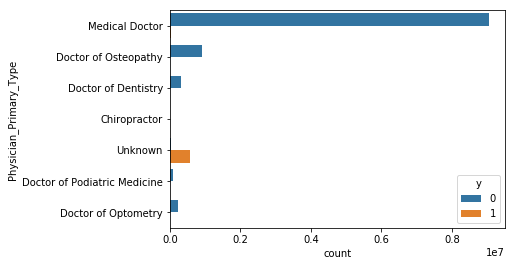

In [15]:
f, ax = plt.subplots()
ax = sns.countplot(y = 'Physician_Primary_Type', hue = 'y', data = df)

In [16]:
df.groupby(['Physician_Primary_Type', 'y']).size()

Physician_Primary_Type        y
Chiropractor                  0       3556
                              1          1
Doctor of Dentistry           0     324981
                              1        382
Doctor of Optometry           0     227078
                              1        356
Doctor of Osteopathy          0     917543
                              1        857
Doctor of Podiatric Medicine  0      99635
                              1         49
Medical Doctor                0    9049297
                              1      23170
Unknown                       0      41743
                              1     577715
dtype: int64

From the tables and figure, we can find that there is a surprising result with the missing values in **Physician_Primary_Type**. Specifically, we see that over 93% of those entries (accounting for ~5% of all data) belong to research transactions (y = 1). Whether this constitutes information leakage, or is indicative of a great feature, is difficult to judge, so in the spirit of avoiding shortcuts, we will remove this feature.

In [25]:
df.drop(['Physician_Primary_Type'], axis = 1, inplace = True)

#### Check missing rate

In [26]:
# check missing
for el in df.columns:
    tmp = df[el].isna().sum()
    if tmp == 0:
        print('0 missing data of feature ' + str(el))
    else:
        print(str(el) + ' has\n number of missing rows : ' + str(tmp) + '\n ratio : ' + str(tmp/df.shape[0]) + '\n')

0 missing data of feature Recipient_State
0 missing data of feature Recipient_Country
0 missing data of feature Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID
0 missing data of feature Total_Amount_of_Payment_USDollars
0 missing data of feature Form_of_Payment_or_Transfer_of_Value
0 missing data of feature Dispute_Status_for_Publication
0 missing data of feature Related_Product_Indicator
0 missing data of feature Covered_or_Noncovered_Indicator_1
0 missing data of feature Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1
0 missing data of feature y


## Baseline model

For building our baseline model, we selected 9 features based on our research and applyied a logistic regression to predict the label. The following features were selected.

1. **Recipient_State** 62 unique values
2. **Recipient_Country** : 3 unique values
3. **Total_Amount_of_Payment_USDollars** real valued
4. **Form_of_Payment_or_Transfer_of_Value** 6 unique values
5. **Dispute_Status_for_Publication** 2 unique values
6. **Related_Product_Indicator** 2 unique values
7. **Covered_or_Noncovered_Indicator_1** 3 unique values
8. **Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1** 6 unique values



In [27]:
# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [28]:
col = [el for el in df.columns if el != 'y']

In [29]:
# sample data
rand = np.random.choice(df.index.values, int(len(df) * 0.001))
s_df = df.ix[rand]

# subset features
X = s_df.loc[:, col]
y = s_df.loc[:,'y']

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 1, 
                                                    stratify = y, 
                                                    train_size = 0.75)


#### Build pipeline using small dataset

In [30]:
# categorical list 
ct_ls = [x for x in col if x != 'Total_Amount_of_Payment_USDollars']

# preprocess pipe
# PowerTransformer() also standardize the data 
preprocess = make_column_transformer(
    (PowerTransformer(),['Total_Amount_of_Payment_USDollars']),
    (OneHotEncoder(sparse = False, handle_unknown='ignore'), ct_ls),
    remainder='passthrough')

# logistic pipe
lr = LogisticRegression(dual = False, solver = "sag", penalty = 'l2')
logistic_pipe = make_pipeline(preprocess, lr) 

In [31]:
# metric we want to use
scoring = {'balanced_accuracy' : 'balanced_accuracy',
           'precision' : 'precision',
           'average_precision' : 'average_precision', 
           'recall' : 'recall',
           'f1' : 'f1'}

In [32]:
# build using small subset
scores = cross_validate(logistic_pipe, X_train, y_train, scoring = scoring)

In [33]:
for el in scores.keys():
    if el == 'fit_time' or el == 'score_time':
        continue
    else:
        print(el + ' : ' + str(np.mean(scores[el])))

test_balanced_accuracy : 0.8397420218125639
train_balanced_accuracy : 0.8726630056588682
test_precision : 0.8260501590866554
train_precision : 0.8822340578231017
test_average_precision : 0.8482536286557143
train_average_precision : 0.8904383342356708
test_recall : 0.6956989247311829
train_recall : 0.7564516129032258
test_f1 : 0.7550262642908642
train_f1 : 0.814425892115101


## Conclusion for task 2

In task 2, we used logistic regression as baseline model algorithm. We used following features to predict the payment label:
1. Recipient_State
2. Recipient_Country
3. Total_Amount_of_Payment_USDollars
4. Form_of_Payment_or_Transfer_of_Value
5. Dispute_Status_for_Publication
6. Related_Product_Indicator
7. Covered_or_Noncovered_Indicator_1
8. Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1

The sample model was built with 10% subset data. The model performance were evaluated using several metrics, given that the dataset is highly imbalanced. We consider the following baseline results relevant for assessing our baseline model:

1. test_balanced_accuracy : 0.8397420218125639
2. test_precision : 0.8260501590866554
3. test_average_precision : 0.8482536286557143
4. test_recall : 0.6956989247311829
5. test_f1 : 0.7550262642908642
